Python Parallelization Report
===

## When is it beneficial to parallelize a groupby function?

Author: Qikai Gu

Date: Sep 6, 2018

---

The objective of this notebook is to study if it's possible to reduce the running time of a groupby function by using parallelization, and in what case it is beneficial to apply a multiprocessing on the groupby function.

Because of the Global Interpreter Lock (GIL), multithreading doesn't give much performance gain, so it isn't included in this report. Here I focus on multiprocessing approaches.

In [1]:
import time
from multiprocessing import Pool, Manager, Lock

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext line_profiler

To do this, a custom dataset format will be defined firstly and I will apply a groupby function on several datasets of the same format in order to better understand the parallelization.

In [2]:
def create_dataset(size, n_groups):
    """
    Create a dataset of key-value pairs of given size, 
    with values equally distributed in n_groups.
    
    For size=10, n_groups=2, the function returns 
    {0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1}
    """
    values = [x  
              for _ in range(size // n_groups)
              for x in list(range(n_groups))] + \
             list(range(n_groups))[:size % n_groups]
    return {i: x for i, x in enumerate(values)}

In [3]:
sample = create_dataset(10, 2)
sample

{0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1}

We are doing a group-keys-by-values action, more precisely, for each unique value, put their keys together.

For this particular sample, the expected output of the groupby function is 
```
{0: [0, 2, 4, 6, 8],
 1: [1, 3, 5, 7, 9]}
```

In [4]:
SIZE = 1000000
N_UNIQUE_VALUES = 1000000

dataset = create_dataset(SIZE, N_UNIQUE_VALUES)

In [5]:
def timeit(func, *args):
    """
    A function to get the execution time of a given function.
    """
    start_time = time.time()
    result = func(*args)
    end_time = time.time()
    exec_time = end_time - start_time
    print('Execution time: {} seconds.'.format(exec_time))
    return result, exec_time

### Groupby with built-in dicts

In [6]:
def groupby_with_dict(d_):
    grouped = {}
    for key, val in d_.items():
        if val not in grouped:
            grouped[val] = []
        grouped[val].append(key)
    return grouped


def bench_dict_groupby():
    size = 10000000
    n_unique_values = [1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
    times = []
    
    for n in n_unique_values:
        print('For {} data points ({} unique values repeated {} times): '.format(
              size, n, size // n))
        d_ = create_dataset(size, n)
        _, t = timeit(groupby_with_dict, d_)
        times.append(t)
        print()
    
    plt.plot(n_unique_values, times, 'x-b')
    plt.xscale('log')
    plt.xlabel('number of unique values')
    plt.ylabel('seconds')
    plt.title('Groupby Execution Time')
    plt.show()

For 10000000 data points (1 unique values repeated 10000000 times): 
Execution time: 0.9850666522979736 seconds.

For 10000000 data points (10 unique values repeated 1000000 times): 
Execution time: 1.047842264175415 seconds.

For 10000000 data points (100 unique values repeated 100000 times): 
Execution time: 1.089705467224121 seconds.

For 10000000 data points (1000 unique values repeated 10000 times): 
Execution time: 1.7152485847473145 seconds.

For 10000000 data points (10000 unique values repeated 1000 times): 
Execution time: 1.822258710861206 seconds.

For 10000000 data points (100000 unique values repeated 100 times): 
Execution time: 1.6639516353607178 seconds.

For 10000000 data points (1000000 unique values repeated 10 times): 
Execution time: 3.015690803527832 seconds.

For 10000000 data points (10000000 unique values repeated 1 times): 
Execution time: 5.911139965057373 seconds.



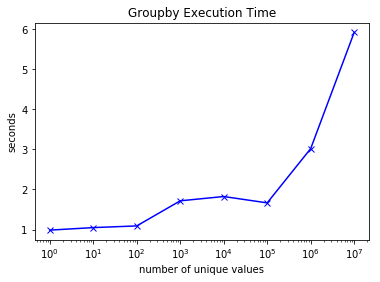

In [7]:
bench_dict_groupby()

For a size fixed dataset, the execution time of the groupby function increases as long as the number of unique values increases.

### Groupby parallelization

Now let's implement a parallelized groupby function. 

The idea is to allow a worker to pick a pair of key-value and give them access to the output variable `grouped`, which is a dictionary of grouped keys. The worker checks if the value exists in `grouped`, if not then initialize the corresponding value of `grouped` with and empty list, then append the list with the key picked by the worker.

It is then possible to spawn multiple workers in parallel and manage them with a processing pool. For the sake of security, I use a lock to avoid race conditions.

In [8]:
grouped = {}
dataset = {}


def groupby(i):
    x = dataset[i]
    
    if x not in grouped:
        grouped[x] = []
    grouped[x].append(i)

    
def groupby_parallel(grouped, i, lock):
    x = dataset[i]
    
    lock.acquire()
    try:
        if x not in grouped:
            grouped[x] = []
        l = grouped[x]
        l.append(i)
        grouped[x] = l
    finally:
        lock.release()


def parallel_groupby(processes=1):
    lock = Manager().Lock()
    grouped = Manager().dict()
    
    pool = Pool(processes)
    for i in range(len(dataset)):
        pool.apply_async(groupby_parallel, 
                         args=(grouped, i, lock), 
                         error_callback=print)
    pool.close()
    pool.join()

    return grouped

In [9]:
# Because the parallel version doesn't perform as well as the 
# mono processing version, I use a smaller dataset for the test.
dataset = create_dataset(100, 10)

Let's see first how much time it takes for monoprocessing.

In [10]:
timeit(groupby_with_dict, dataset)
print()

Execution time: 1.7642974853515625e-05 seconds.



Now multiprocessing with number of processes ranging from 1 to 6.

In [11]:
for n_proc in range(1, 7):
    print('Number of processes: {}'.format(n_proc))
    timeit(parallel_groupby, n_proc)
    print()

Number of processes: 1
Execution time: 0.40412473678588867 seconds.

Number of processes: 2
Execution time: 0.3969917297363281 seconds.

Number of processes: 3
Execution time: 0.4205503463745117 seconds.

Number of processes: 4
Execution time: 0.4770534038543701 seconds.

Number of processes: 5
Execution time: 0.36072754859924316 seconds.

Number of processes: 6
Execution time: 0.4008660316467285 seconds.



It shows that the multiprocessing version is much slower than the monoprocessing version and the execution time increases as long as the number of processes increases. Let's find out the reason with line_profiler.

In [12]:
%lprun -f parallel_groupby parallel_groupby(1)

```
Timer unit: 1e-06 s

Total time: 0.451016 s
File: <ipython-input-8-a537cc417d00>
Function: parallel_groupby at line 27

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    27                                           def parallel_groupby(processes=1):
    28         1      42566.0  42566.0      9.4      lock = Manager().Lock()
    29         1      45416.0  45416.0     10.1      grouped = Manager().dict()
    30                                               
    31         1      34143.0  34143.0      7.6      pool = Pool(processes)
    32       101         61.0      0.6      0.0      for i in range(len(dataset)):
    33       100         62.0      0.6      0.0          pool.apply_async(groupby_parallel, 
    34       100         54.0      0.5      0.0                           args=(grouped, i, lock), 
    35       100       2622.0     26.2      0.6                           error_callback=print)
    36         1          5.0      5.0      0.0      pool.close()
    37         1     326085.0 326085.0     72.3      pool.join()
    38                                           
    39         1          2.0      2.0      0.0      return grouped
```

In [13]:
%lprun -f parallel_groupby parallel_groupby(6)

```
Timer unit: 1e-06 s

Total time: 0.483422 s
File: <ipython-input-8-a537cc417d00>
Function: parallel_groupby at line 27

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    27                                           def parallel_groupby(processes=1):
    28         1      39064.0  39064.0      8.1      lock = Manager().Lock()
    29         1      34442.0  34442.0      7.1      grouped = Manager().dict()
    30                                               
    31         1     165277.0 165277.0     34.2      pool = Pool(processes)
    32       101         42.0      0.4      0.0      for i in range(len(dataset)):
    33       100         53.0      0.5      0.0          pool.apply_async(groupby_parallel, 
    34       100         39.0      0.4      0.0                           args=(grouped, i, lock), 
    35       100       1937.0     19.4      0.4                           error_callback=print)
    36         1          3.0      3.0      0.0      pool.close()
    37         1     242563.0 242563.0     50.2      pool.join()
    38                                           
    39         1          2.0      2.0      0.0      return grouped
```

I ran profiling over the same function at line level with two different parameters, i.e. processes=1 and processes=6.

- The initialization of the lock (line \#28) and shared dictionary (line \#29) is time-consuming. 
- The process pool initialization (line \#31) spent 6 times initializing 6 processes as long as initializing a single process.
- The actual execution of of tasks (line \#37) takes also much time because of the lock acquirement and release, which leads to more execution time while there's more processes.

It turns out for this particular groupby task, multiprocessing doesn't help reduce the execution time. The reason might be:
1. The output is a shared object. The race condition has to be handled. If the task doesn't require any shared object, multiprocessing will probably reduce the execution time.
2. For a single task, it does mainly updating the share object, i.e. appending elements. It means that there's little time gap between two lock acquired periods, so there is very little computation in parallel actually.

To verify these assumptions, I am going to run 2 tests in the following section.
1. A test with more time gap between two lock acquired periods by adding `time.sleep()` before `lock.acquire()`.
2. On top of the first test, replace the `groupby` function by another function which doesn't require to write into a shared object.

##### Test 1 - Tasks with more content and writing to shared objects

In [14]:
grouped = {}
dataset = {}


def groupby(i, sleep=0):
    if sleep > 0:
        time.sleep(sleep)
    x = dataset[i]
    
    if x not in grouped:
        grouped[x] = []
    grouped[x].append(i)

    
def groupby_parallel(grouped, i, lock, sleep):
    if sleep > 0:
        time.sleep(sleep)
    x = dataset[i]
    
    lock.acquire()
    try:
        if x not in grouped:
            grouped[x] = []
        l = grouped[x]
        l.append(i)
        grouped[x] = l
    finally:
        lock.release()


def parallel_groupby(processes=1, sleep=0):
    lock = Manager().Lock()
    grouped = Manager().dict()
    
    pool = Pool(processes)
    for i in range(len(dataset)):
        pool.apply_async(groupby_parallel, 
                         args=(grouped, i, lock, sleep), 
                         error_callback=print)
    pool.close()
    pool.join()

    return grouped

In [15]:
dataset = create_dataset(1000, 1000)
sleep_time = 0.01

How much time does it take for mono processing?

In [16]:
_ = timeit(lambda x: [groupby(i, sleep_time) for i in range(len(dataset))], 0)

Execution time: 10.075932502746582 seconds.


Number of processes: 1
Execution time: 12.128713130950928 seconds.

Number of processes: 2
Execution time: 6.413443565368652 seconds.

Number of processes: 3
Execution time: 4.227025270462036 seconds.

Number of processes: 4
Execution time: 3.3626174926757812 seconds.

Number of processes: 5
Execution time: 2.7863504886627197 seconds.

Number of processes: 6
Execution time: 2.4401535987854004 seconds.



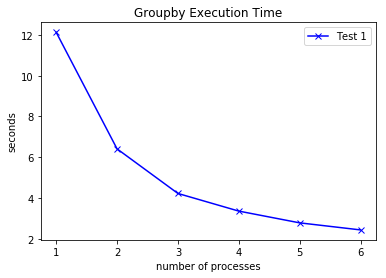

In [17]:
n_procs = list(range(1, 7))
test1_times = []

for n_proc in n_procs:
    print('Number of processes: {}'.format(n_proc))
    _, t = timeit(parallel_groupby, n_proc, sleep_time)
    test1_times.append(t)
    print()

plt.plot(n_procs, test1_times, 'x-b', label='Test 1')
plt.legend()
plt.xlabel('number of processes')
plt.ylabel('seconds')
plt.title('Groupby Execution Time')
plt.show()

By adding more content in the task, it makes more time gap between locks, so that more parallel tasks can be run.

##### Test 2 - Tasks with more content but without writing to shared objects

In [18]:
def square(n, sleep=0):
    if sleep > 0:
        time.sleep(sleep)  # a line of time-consuming code
    return n * n


def parallel_square(processes=1, sleep=0):
    pool = Pool(processes)
    for i in range(len(dataset)):
        pool.apply_async(square, 
                         args=(i, sleep), 
                         error_callback=print)
    pool.close()
    pool.join()

How much time does it take for mono processing?

In [19]:
_ = timeit(lambda x: [square(i, sleep_time) for i in range(len(dataset))], 0)

Execution time: 10.09703016281128 seconds.


Number of processes: 1
Execution time: 10.335002422332764 seconds.

Number of processes: 2
Execution time: 5.261218070983887 seconds.

Number of processes: 3
Execution time: 3.5759522914886475 seconds.

Number of processes: 4
Execution time: 2.8167879581451416 seconds.

Number of processes: 5
Execution time: 2.340592861175537 seconds.

Number of processes: 6
Execution time: 2.044273614883423 seconds.



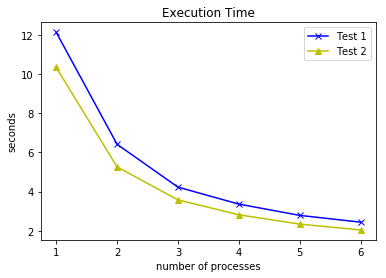

In [20]:
test2_times = []


for n_proc in n_procs:
    print('Number of processes: {}'.format(n_proc))
    _, t = timeit(parallel_square, n_proc, sleep_time)
    test2_times.append(t)
    print()

plt.plot(n_procs, test1_times, 'x-b', label='Test 1')
plt.plot(n_procs, test2_times, '^-y', label='Test 2')
plt.legend()
plt.xlabel('number of processes')
plt.ylabel('seconds')
plt.title('Execution Time')
plt.show()

From the graph, test 2 has less execution time than test 1. It verifies the first assumption, writing in shared objects costs more time.

#### Does it matter the number of unique values?

In [21]:
n_unique_values = [1, 10, 100, 1000]
times_list = []
for n_vals in n_unique_values:
    print('=== Number of unique values: {} ==='.format(n_vals))
    dataset = create_dataset(1000, n_vals)
    times = []
    for n_proc in n_procs:
        print('Number of processes: {}'.format(n_proc))
        _, t = timeit(parallel_groupby, n_proc, sleep_time)
        times.append(t)
    times_list.append(times)
    print()

=== Number of unique values: 1 ===
Number of processes: 1
Execution time: 12.10879111289978 seconds.
Number of processes: 2
Execution time: 6.425269365310669 seconds.
Number of processes: 3
Execution time: 4.243856191635132 seconds.
Number of processes: 4
Execution time: 3.3686439990997314 seconds.
Number of processes: 5
Execution time: 2.80482816696167 seconds.
Number of processes: 6
Execution time: 2.431624174118042 seconds.

=== Number of unique values: 10 ===
Number of processes: 1
Execution time: 12.109933614730835 seconds.
Number of processes: 2
Execution time: 6.314509391784668 seconds.
Number of processes: 3
Execution time: 4.224473714828491 seconds.
Number of processes: 4
Execution time: 3.2659876346588135 seconds.
Number of processes: 5
Execution time: 2.7825238704681396 seconds.
Number of processes: 6
Execution time: 2.453310489654541 seconds.

=== Number of unique values: 100 ===
Number of processes: 1
Execution time: 12.116395950317383 seconds.
Number of processes: 2
Execu

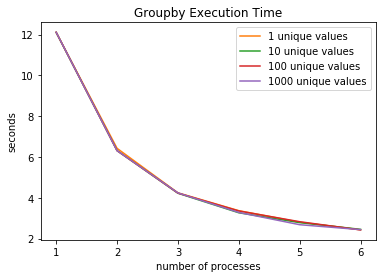

In [22]:
for i, n_vals in enumerate(n_unique_values):
    plt.plot(n_procs, times_list[i], 'C{}'.format(i + 1), 
             label='{} unique values'.format(n_vals))
plt.legend()
plt.xlabel('number of processes')
plt.ylabel('seconds')
plt.title('Groupby Execution Time')
plt.show()

For the parallel groupby function, the number of unique values doesn't matter the execution time.

### Conclusion

1. For a groupby function, if the majority of the task is modifying shared objects, then mono processing works better in most case. Otherwise, multiprocessing will probably reduce the running time.
2. In the latter case, the distribution of values doesn't matter the running time of the groupby function.